<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv5 from Ultralytics
This notebook showcases the newly added [YOLOv5](https://github.com/ultralytics/yolov5) suite of models to the IceVision library.


## Installing IceVision, IceData and `yolov5-icevision`
`yolov5-icevision` is a tiny IceVision wrapper around the official YOLOv5 repo from Ultralytics, to make the code pip-installable.

Install from pypi...

In [1]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11 master

## Imports

In [1]:
from icevision.all import *
import icedata

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:69


## Loading the Fridge dataset

In [2]:
data_dir = icedata.fridge.load_data()

class_map = ClassMap(["milk_bottle", "carton", "can", "water_bottle"])
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations",
                     images_dir=data_dir / "odFridgeObjects/images",
                     class_map=class_map)

train_records, valid_records = parser.parse()

presize = 512
size = 384
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

len(train_ds), len(valid_ds)

  0%|          | 0/20380998 [00:00<?, ?B/s]

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


(102, 26)

## YOLOv5 dataloaders

In [5]:
model_type = models.ultralytics.yolov5

In [6]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=2, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=2, shuffle=False)

Showing what's inside a batch

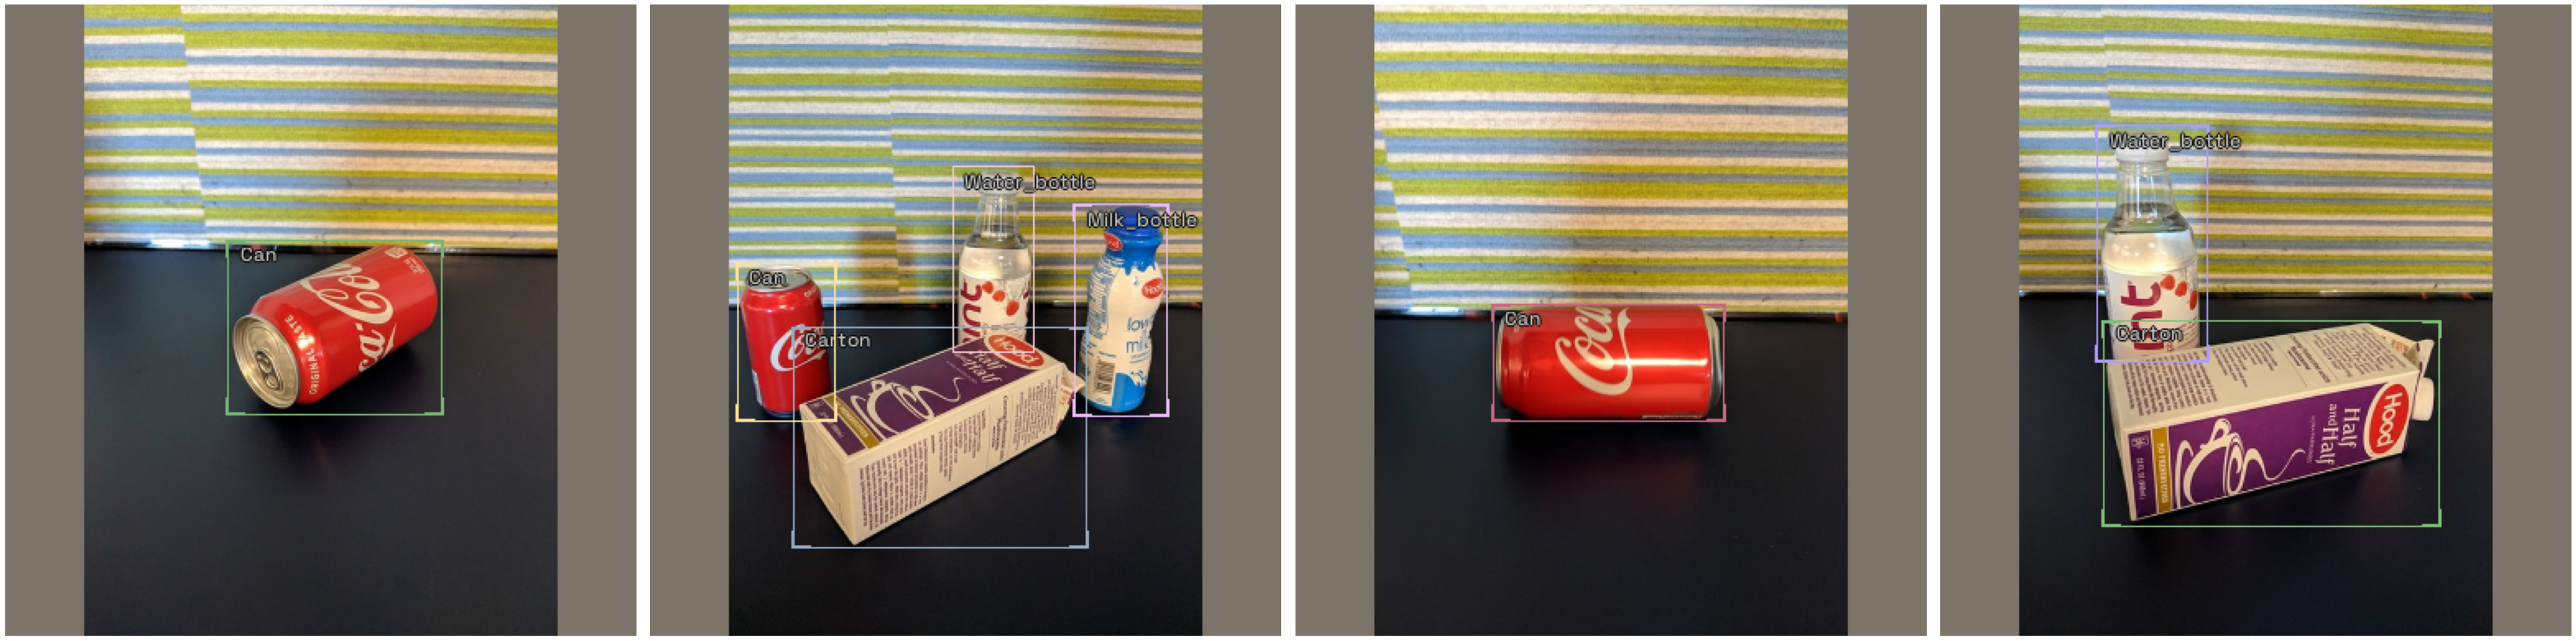

In [7]:
dl = model_type.valid_dl(valid_ds, batch_size=4, num_workers=2, shuffle=False)
batch = first(dl)
model_type.show_batch(batch, ncols=4)

## YOLOv5 model
You can choose between a `small`, `medium` and `large` backbone.

In [8]:
backbone = model_type.backbones.small(pretrained=True)
#backbone = model_type.backbones.medium(pretrained=True)
#backbone = model_type.backbones.large(pretrained=True)
#backbone = model_type.backbones.extra_large(pretrained=True)

model = model_type.model(backbone=backbone, num_classes=parser.class_map.num_classes, img_size=size, device=torch.device("cuda"))

  0%|          | 0.00/14.1M [00:00<?, ?B/s]

## Training a fastai Learner

In [9]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=9.12010818865383e-07)

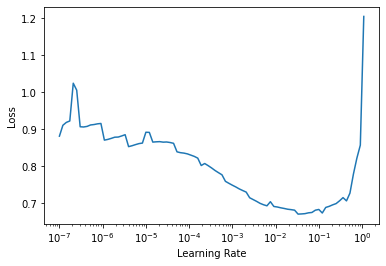

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(50, 3e-4)

### Showing training results

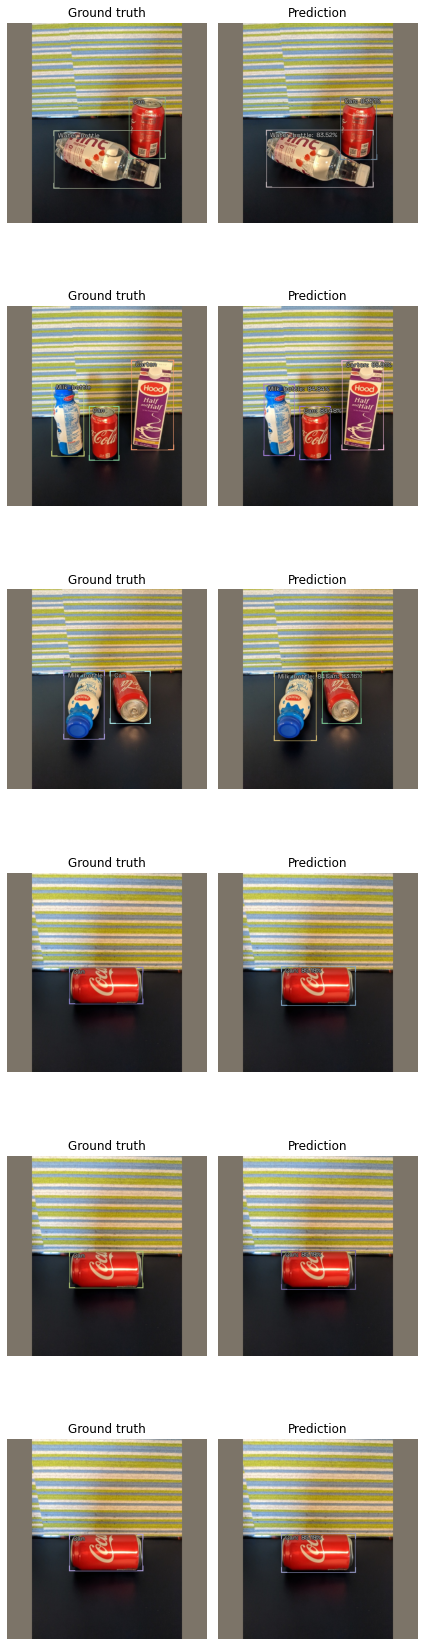

In [12]:
model_type.show_results(model, valid_ds, detection_threshold=0.25)

## Inference pipeline
From a dataset...

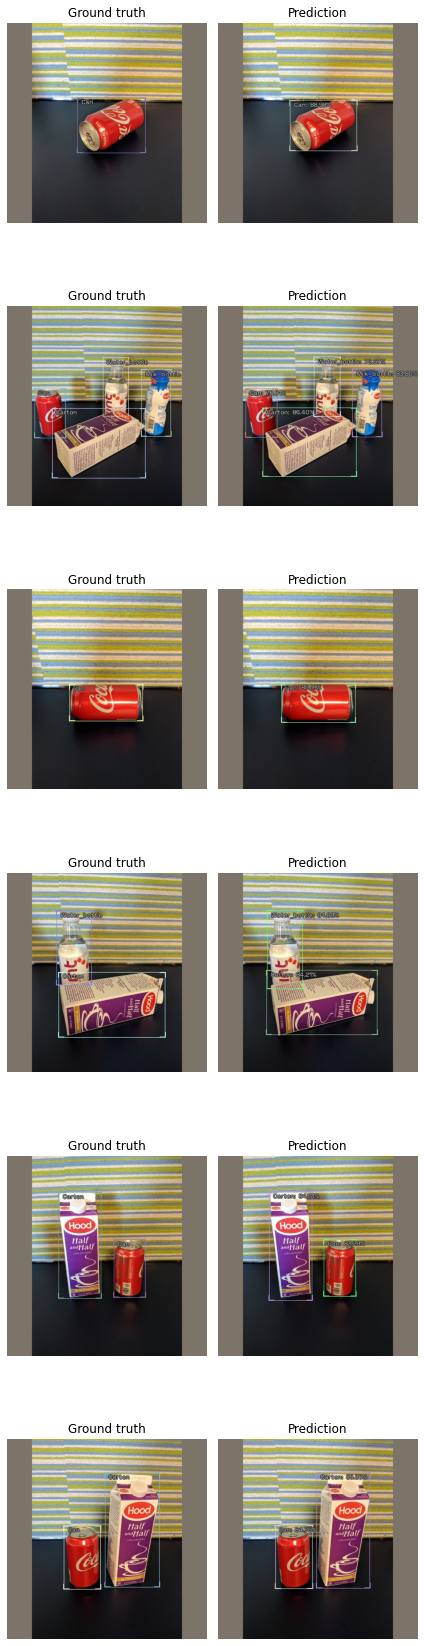

In [13]:
preds = model_type.predict(model, valid_ds, detection_threshold=0.25)

show_preds(
    preds=preds[:6],
    denormalize_fn=denormalize_imagenet,
    ncols=3,
)

... and from a Dataloader

  0%|          | 0/26 [00:00<?, ?it/s]

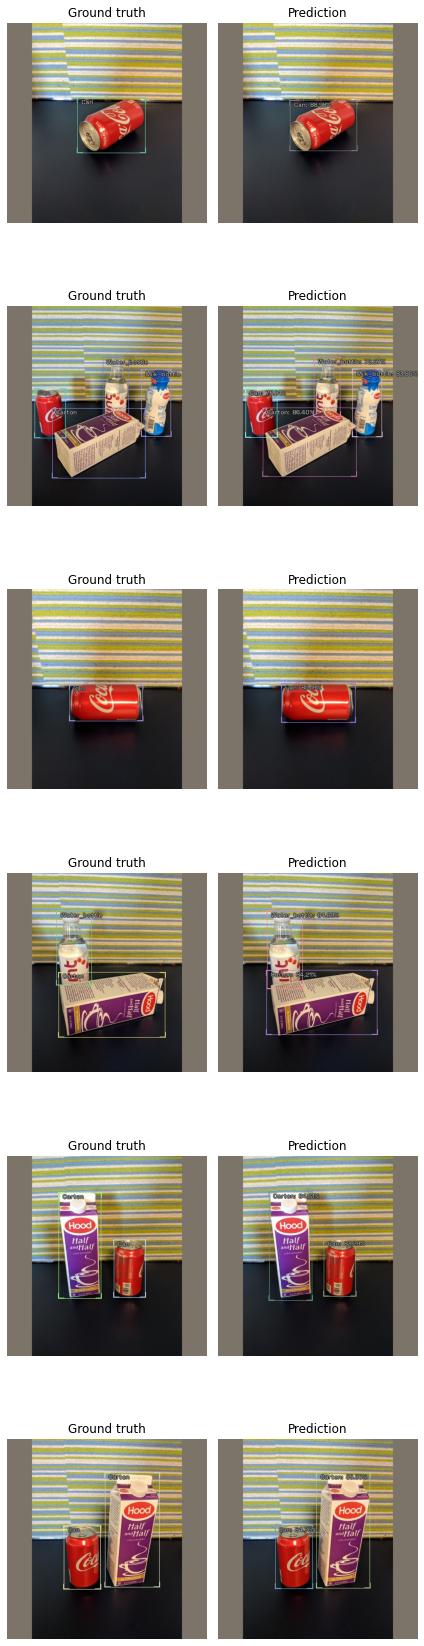

In [14]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=1, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, detection_threshold=0.25, keep_images=True)

show_preds(
    preds=preds[:6],
    denormalize_fn=denormalize_imagenet,
    ncols=3,
)

## Inspecting model predictions with `plot_top_losses`

What are the images the model is having a hard time time with?

INFO     - Losses returned by model: ['loss_yolo'] | icevision.models.interpretation:plot_top_losses:219


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

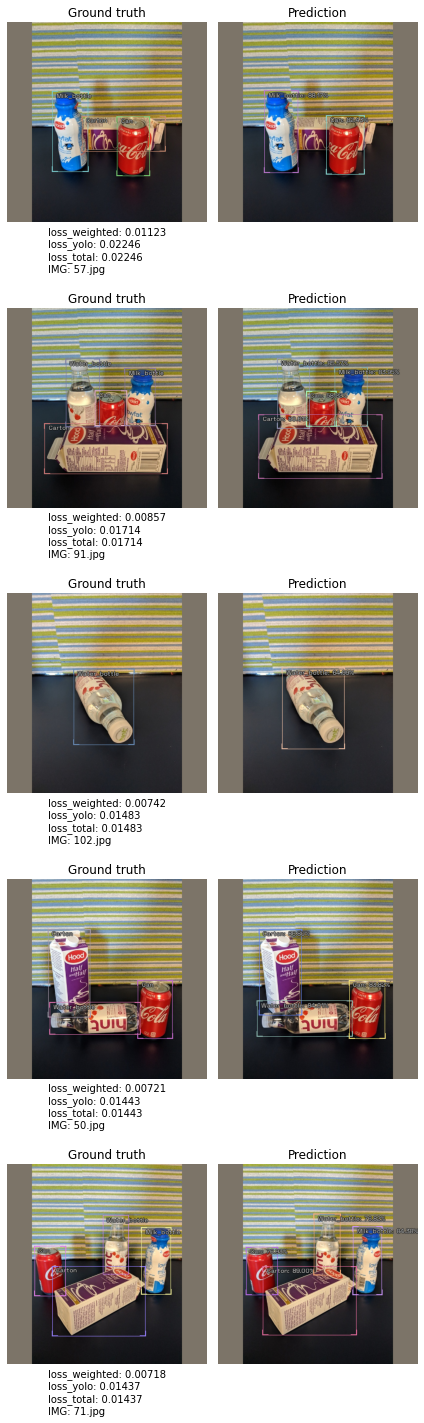

In [15]:
#by = "loss_total"
#by = "loss_yolo"
by = {
        "method": "weighted",
        "weights": {
            "loss_yolo": 0.5,
        },
    }

sorted_samples, sorted_preds, losses_stats = model_type.interp.plot_top_losses(model, valid_ds, sort_by=by)

## Training a PyTorch Lightning model

In [16]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=3e-4)

backbone = model_type.backbones.medium(pretrained=True)
model = model_type.model(backbone=backbone, num_classes=parser.class_map.num_classes, img_size=size)

light_model = LightModel(model, metrics=metrics)

trainer = pl.Trainer(max_epochs=30, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

  0%|          | 0.00/41.1M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 21.1 M
--------------------------------
21.1 M    Trainable params
0         Non-trainable params
21.1 M    Total params
84.290    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).
